# Lab session 6: Recurrent Neural Networks (RNN)

Authors: [pierre.tandeo@imt-atlantique.fr](pierre.tandeo@imt-atlantique.fr), [lucas.drumetz@imt-atlantique.fr](lucas.drumetz@imt-atlantique.fr), [claire.scavinner-dorval@imt-atlantique.fr](claire.scavinner-dorval@imt-atlantique.fr), [sarah.reynaud@imt-atlantique.fr](sarah.reynaud@imt-atlantique.fr), [hugo.georgenthum@imt-atlantique.fr](hugo.georgenthum@imt-atlantique.fr)

Year: 2023-2024

Student 1: MAHMOUDI Sarra

Student 2: Jean YAPO

In this practice, we will use a Recurrent Neural Networks (RNN) to fit multivariate time series and to make some predictions in the future. We will use the Lorenz-63 chaotic model, also known as the strange attractor (see https://en.wikipedia.org/wiki/Lorenz_system for more details).

First, we will generate and visualize trajectories from the Lorenz-63 system. From these data, we will build training and test datasets. Then, we will adjust two models to fit the data: a classic linear autoregressive model and the specific LSTM (Long Short-Term Memory) architecture of RNN. Finally, we will compare these models in terms of prediction and simulation of new trajectories.

In [1]:
# Import libraries
%pylab inline
%matplotlib inline

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Parameters (figure size)
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


**A few words about the use of GPUs**

In order to accelerate the optimization of your LSTM, we suggest to use GPUs. In Google Colab, you will need to enable GPUs for the notebook:
* navigate to Edit → Notebook Settings
* select GPU from the Hardware Accelerator drop-down

Then, the use of GPU in PyTorch is based on four steps:
* declare the GPU device (cell below)
* transfer the training data to the GPU
* use the GPU to learn the model
* transfer the results to the CPU

You will find more explanations here: https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99.

In [2]:
# Declare the GPU (its name is "device")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Generate data**

Below, we define the 3-dimensional Lorenz-63 model given by:
\begin{aligned}{\frac {\mathrm {d} x_1}{\mathrm {d} t}}&=\sigma (x_2-x_1),\\[6pt]{\frac {\mathrm {d} x_2}{\mathrm {d} t}}&=x_1(\rho -x_3)-x_2,\\[6pt]{\frac {\mathrm {d} x_3}{\mathrm {d} t}}&=x_1 x_2-\beta x_3.\end{aligned}

This ordinary differential equation is using 3 physical parameters and we fix them to $\sigma=10$, $\rho=28$ and $\beta=8/3$. Then, we use Runge-Kutta 4-5 to integrate the model, using the *odeint()* Python function. The integration time is $0.01$ and we generate a sequence of $100$ Lorenz times.

In [3]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [4]:
from scipy.integrate import odeint

# Define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# Generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma,rho,beta))
time = arange(0.01,T,dt)

# Transform array to tensor
x = torch.from_numpy(x).float()

**Visualize data**

They are 2 ways of visualizing the Lorenz-63 system. The first is to consider the system as a 3-dimensional time series: we plot each variable as a function of time. The second is the phase-space representation where we plot the relationships between variables in 3D and we track the trajectory along time.

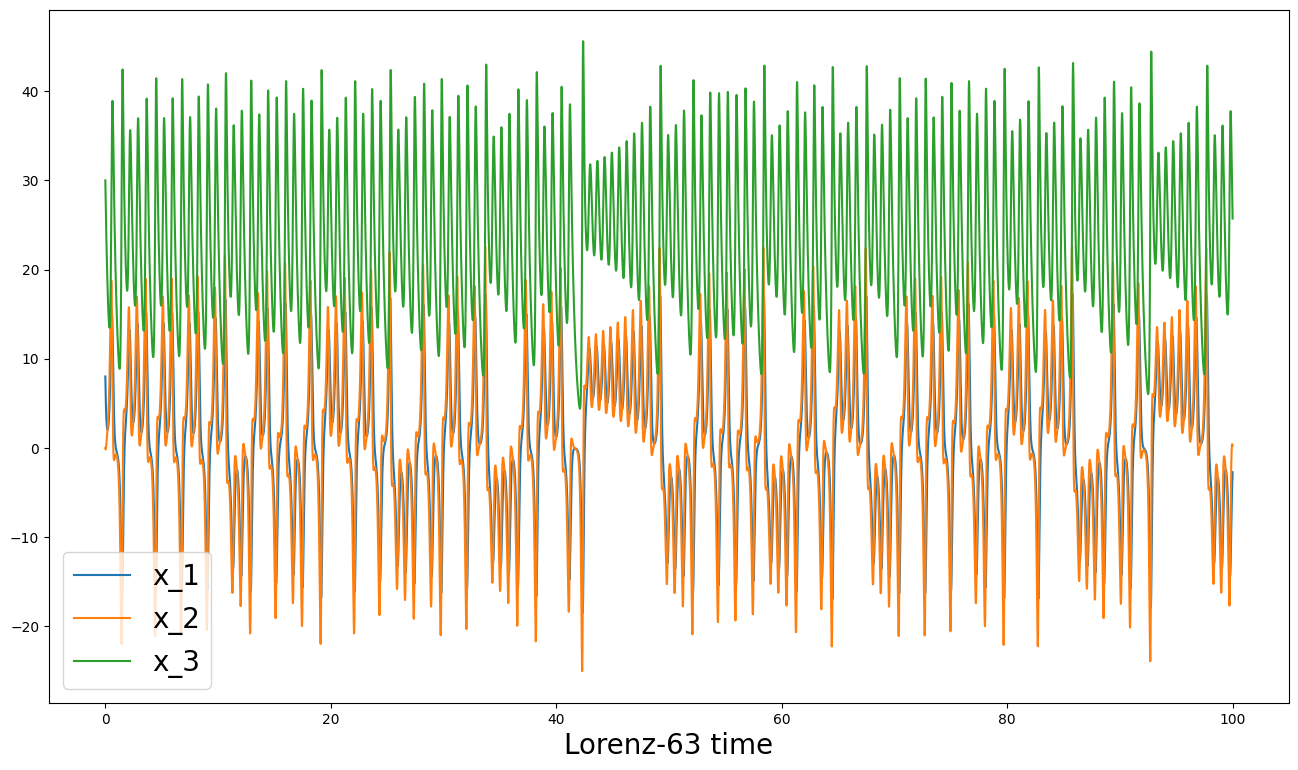

In [5]:
# Time series representation
plot(time, x)
xlabel('Lorenz-63 time', size=20)
legend(['x_1','x_2','x_3'], fontsize=20)

Text(0.5, 0, '$x_3$')

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


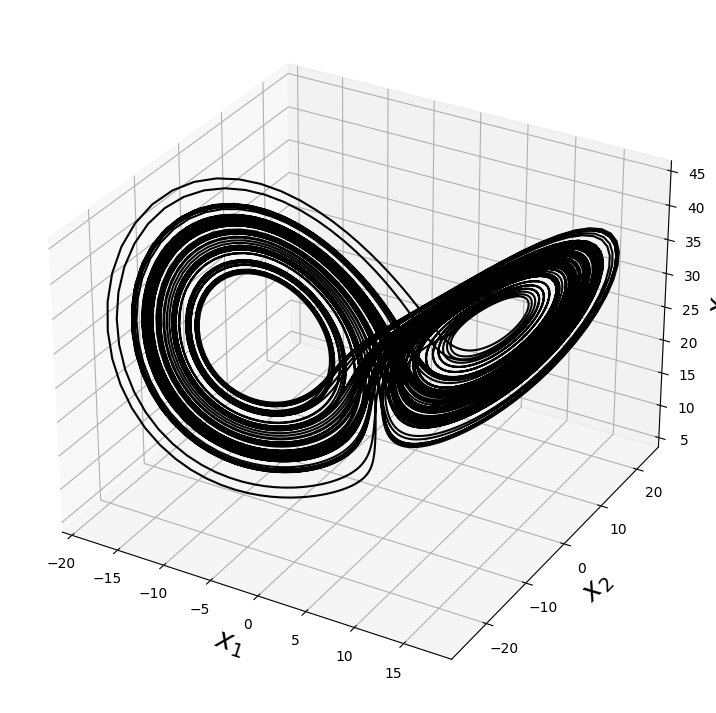

In [ ]:
# Phase-space representation
from mpl_toolkits.mplot3d import Axes3D
fig = figure()
ax = fig.add_subplot(projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2], 'k')
ax.set_xlabel('$x_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)

**Create the training and test datasets**

Here, we want to predict the Lorenz-63 system at time t using the previous information at time t-0.01. It is thus a regression between the process and himself with a time delay. Here, we create a training (the first 2/3 of time series) and a test dataset (the last part).

In [6]:
# Size of the training set
T_train = int(T/dt*2/3)


# Training set
x_train = x[0:T_train,:]
y_train = x[1:T_train+1,:]

# Validation set
x_test = x[T_train+1:-1,]
y_test = x[T_train+2:,]

**Question 1:**

For the 3 components of the Lorenz-63 system, plot *y_train* as a function of *x_train* and comment the relationship. What is happening if we increase the time delay (currently set to $0.01$) between *x_train* and *y_train*?

 1) *We plot y_train in function of x_train with a learning rate og 0.01*

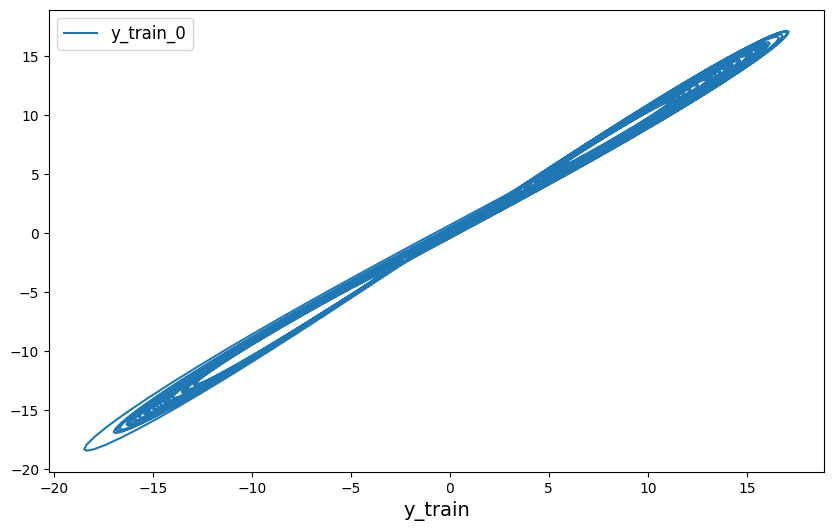

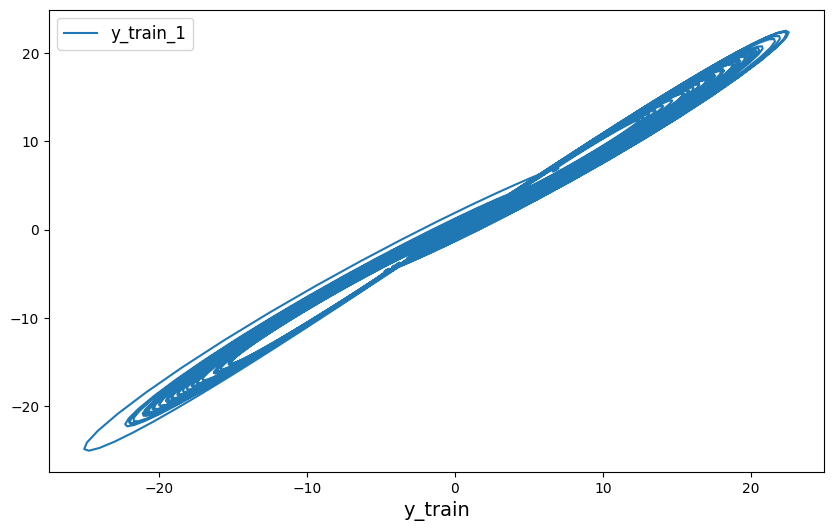

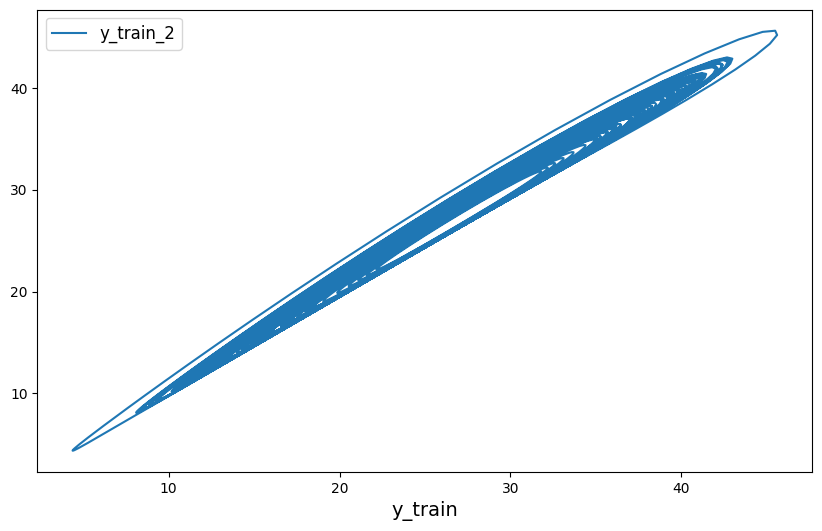

In [12]:
import matplotlib.pyplot as plt



for i in range(3):

    plt.figure(figsize=(10, 6))
    plt.plot(x_train[:, i],y_train[:, i], label=f'y_train_{i}')
    plt.xlabel('x_train', size=14)
    plt.xlabel('y_train', size=14)
    plt.legend(fontsize=12)
    plt.show()


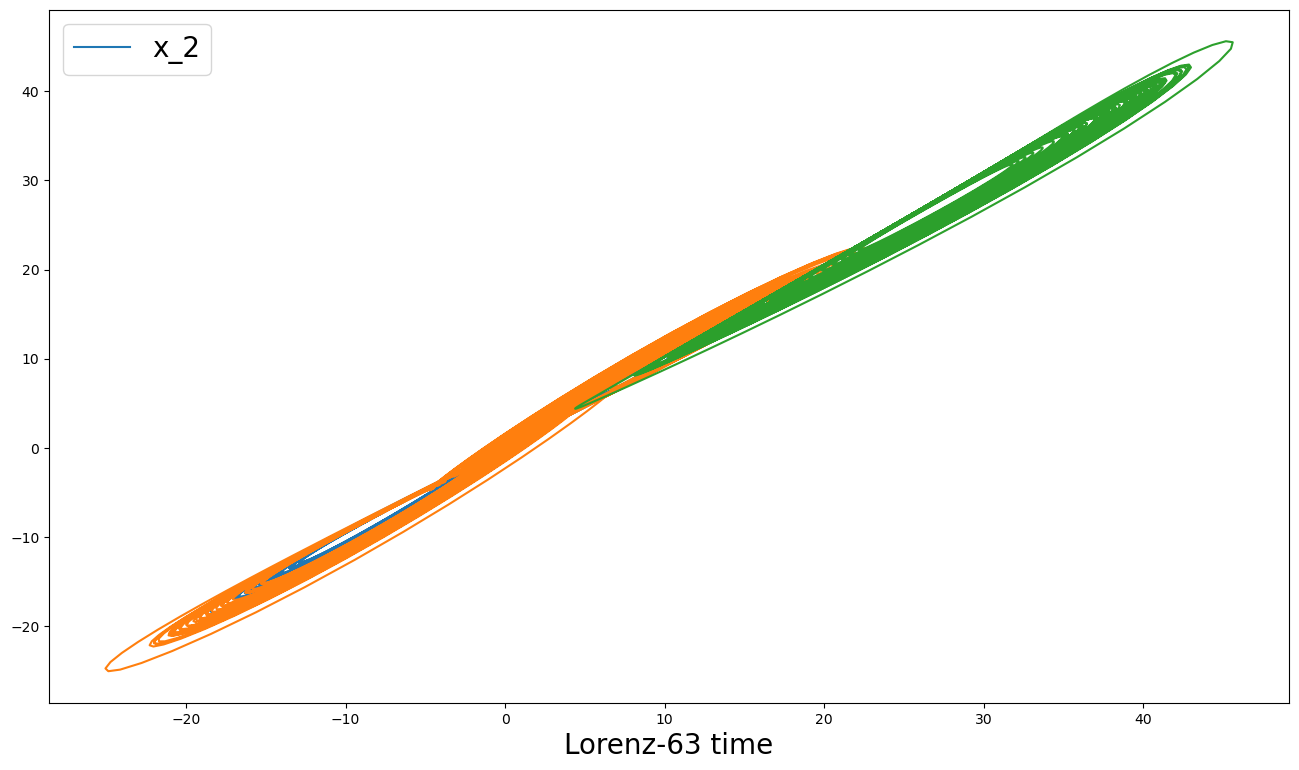

In [ ]:
# Time series representation
# x1_train
for i in range(3):
   plot(y_train[:,i], x_train[:,i])
   xlabel('Lorenz-63 time', size=20)
   legend(['x_' + str(i)], fontsize=20)

 2) *We plot y_train in function of x_train with a learning rate og 0.05*

In [77]:
# Size of the training set
dt=0.05
T_train = int(T/dt*2/3)

In [78]:
# Size of the training set
T_train = int(T/dt*2/3)


# Training set
x_train = x[0:T_train,:]
y_train = x[1:T_train+1,:]

# Validation set
x_test = x[T_train+1:-1,]
y_test = x[T_train+2:,]

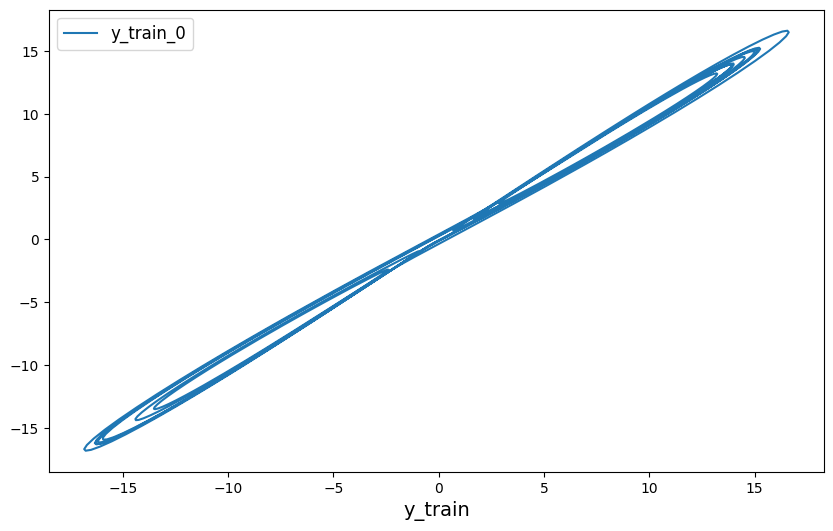

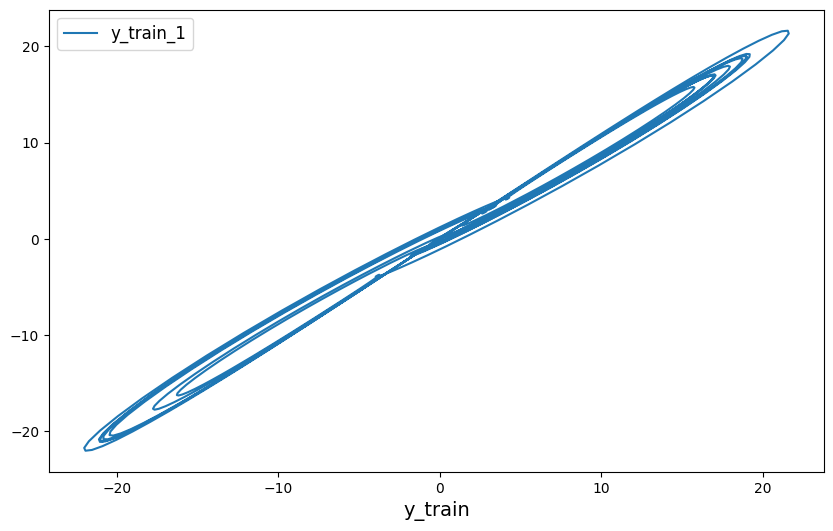

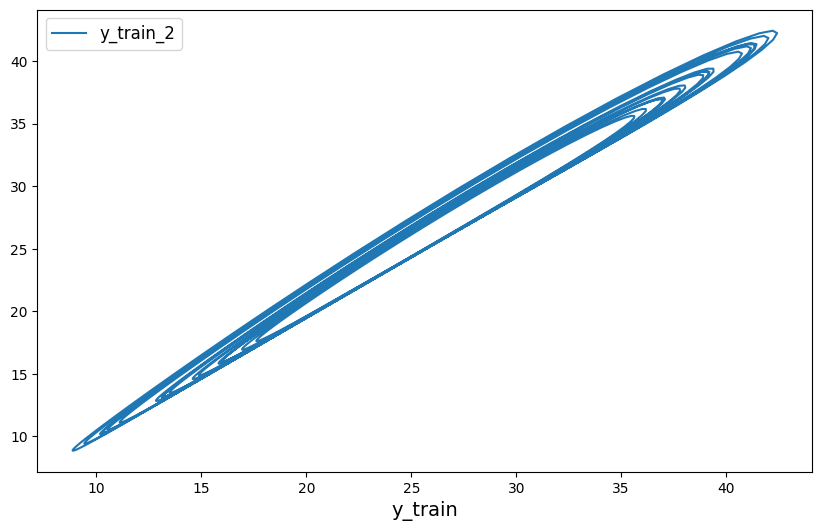

In [79]:

for i in range(3):

    plt.figure(figsize=(10, 6))
    plt.plot(x_train[:, i],y_train[:, i], label=f'y_train_{i}')
    plt.xlabel('x_train', size=14)
    plt.xlabel('y_train', size=14)
    plt.legend(fontsize=12)
    plt.show()

**Response:**

We are trying to predict x(t+dt) and plot them, so the bigger the dt, the
 larger time delay will result in a shifted relationship between x_train and y_train. This is because a larger time delay meanswe are comparing the state of the system at more distant time points.

**Question 2:**

According to the previous question, propose a linear regression between *y_train* (at time t) and *x_train* (at time t-0.01). It corresponds to a multivariate order 1 autoregressive process noted AR(1), see more details here (https://en.wikipedia.org/wiki/Autoregressive_model).

Implement the AR(1) regression using a neural network architecture (see lab session 1 & 2). Call your model *model_AR1*. Can you comment the estimated weights of the resulting neural network?

In [13]:
 # Declare a class for linear regression
class linear_regression_nn(nn.Module):

    # class initialization
    def __init__(self, input_size, output_size):
        super(linear_regression_nn, self).__init__()
        # fully connected layer with linear activation
        self.fc = nn.Linear(input_size, output_size)

    # function to apply the neural network
    def forward(self, x):
        y_pred = self.fc(x)
        return y_pred

In [14]:
# Create the neural network (1 input size for x and 1 output size for y, bias is declared by default)
AR_1 = linear_regression_nn(3, 3)

# Print the model architecture
print(AR_1)

# Print the model parameters (weights of the neural network)
slope, bias = AR_1.parameters()
print('Slope: ', slope)
print('Bias: ', bias)

linear_regression_nn(
  (fc): Linear(in_features=3, out_features=3, bias=True)
)
Slope:  Parameter containing:
tensor([[-0.3788,  0.5499,  0.3302],
        [-0.3836,  0.5633, -0.2910],
        [-0.0094, -0.1778,  0.0442]], requires_grad=True)
Bias:  Parameter containing:
tensor([ 0.0934, -0.3109,  0.3547], requires_grad=True)


In [15]:
# Loss function: MSE = sum [(y - y_pred)^2], with y_pred = w0 + w1*x
criterion = nn.MSELoss()

# Optimizer: new_parameters = old_parameters - lr*gradient, with lr the learning rate
optimizer = torch.optim.SGD(AR_1.parameters(), lr = 0.001)

In [16]:
epochs = 1000 # number of epochs
losses = [] # list to stock the loss at each iteration

# Loop on epochs
for i in range(epochs):

    # compute the prediction using the previous parameters of the neural network
    y_pred = AR_1.forward(x_train)

    # compute and stock the loss
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())

    # initialize the gradient to zero
    optimizer.zero_grad()

    # compute the gradient by back propagation
    loss.backward()

    # update the parameter values using the gradient
    optimizer.step()


Text(0, 0.5, 'Loss value')

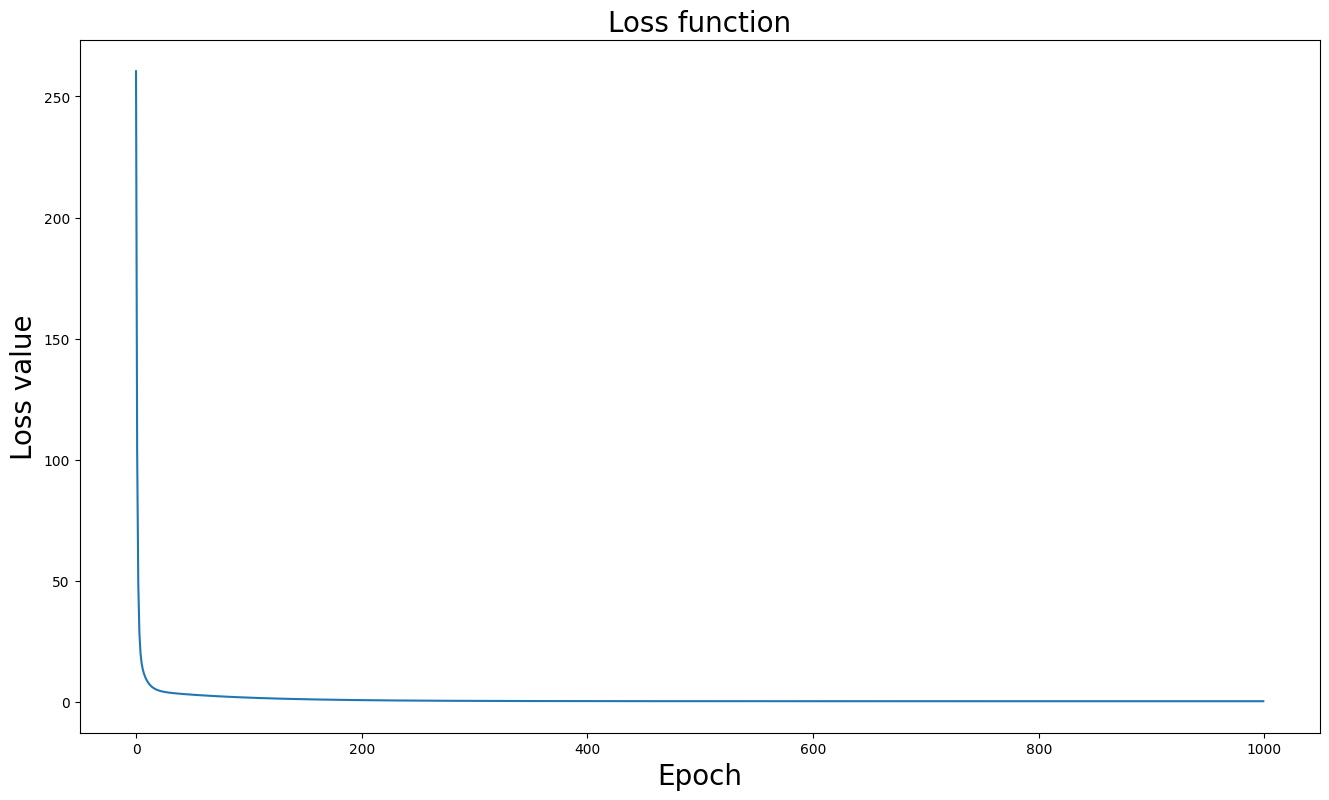

In [17]:
# Print the loss function
plot(range(epochs), losses)
title('Loss function', size=20)
xlabel('Epoch', size=20)
ylabel('Loss value', size=20)

In [18]:
losses[999]

array(0.29907444, dtype=float32)

In [ ]:
slope, bias = AR_1.parameters()
print('Slope: ', slope)
print('Bias: ', bias)

Slope:  Parameter containing:
tensor([[ 0.8964,  0.1018,  0.0135],
        [-0.1232,  1.0906, -0.0152],
        [-0.0014,  0.0028,  0.9892]], requires_grad=True)
Bias:  Parameter containing:
tensor([-0.3583,  0.4318,  0.2733], requires_grad=True)


**Response:**
The bias:
In the first represntation of the data (Lorenz-63 time), we notice that the representtion of the data is quiet horizontal
The Bias vector we get after traing the model, tends toward values close to 0.
We notice, that when it comes to the matrix of M, strating from rendom weights, the model tends to create an Identity matrix.

**Conclusion:** We notice that by mutiplying the input by the identity matrix, and then, by adding close to zero biases, the model tends to creating predicted values, as identitical to the original ones as possible

**Question 3:**

Now, use a RNN architecture to learn the variations of the time series. To do so, we use the *LSTM()* function from PyTorch. Below, we provide you the dataset and a LSTM class. Here, we recommend that you use GPU acceleration.

After implementing and fitting your RNN, have a look at the estimated parameters: what do they represent? See https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html for more details.

First, we have to rearange the dataset used to train the RNN. We also store the dataset on the GPU.

In [19]:
# Reshape train and test data (with batch_size = 1)
x_train_LSTM = reshape(x_train, (shape(x_train)[0], 1, shape(x_train)[1]))
x_test_LSTM = reshape(x_test, (shape(x_test)[0], 1, shape(x_test)[1]))
y_train_LSTM = reshape(y_train, (shape(y_train)[0], 1, shape(y_train)[1]))
y_test_LSTM = reshape(y_test, (shape(y_test)[0], 1, shape(y_test)[1]))

# Store the data on the GPU
x_train_LSTM, x_test_LSTM = x_train_LSTM.to(device), x_test_LSTM.to(device)
y_train_LSTM, y_test_LSTM = y_train_LSTM.to(device), y_test_LSTM.to(device)

Then, we suggest to use the following RNN architecture with one LSTM layer and a fully connected layer with linear activation.

In [20]:
# Declare a class for LSTM
class LSTM_nn(nn.Module):

    # class initialization
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_nn, self).__init__()
        # LSTM layer with 1 hidden layer (hidden_size neurons inside)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = 1)
        # fully connected layer with linear activation
        self.fc = nn.Linear(hidden_size, output_size)

    # function to apply the neural network
    def forward(self, x):
        out, (h_out, c_out) = self.lstm(x)
        y_pred = self.fc(out)
        return y_pred, h_out, c_out

    # function to apply the neural network (when knowing the hidden state)
    def forward_using_last_hidden_layer(self, x, h, c):##we use it, because we want to predict starting from a time t+dt(that we don;t know)and we have to knoe the h(t+dt-1)......, that;s why we use this one
        out, (h_out, c_out) = self.lstm(x, (h, c))
        y_pred = self.fc(out)
        return y_pred, h_out, c_out

In the next cell, we initialize a LSTM with 10 neurons in the hidden layer. Here, we transfer the LSTM model to the GPU.

In [24]:
# Create the LSTM (3 input size for x and 3 output size for y, 10 neurons in the hidden layer)
model_RNN = LSTM_nn(3, 10, 3)

# Use the GPU to train the model
model_RNN.to(device)

LSTM_nn(
  (lstm): LSTM(3, 10)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)

Then, you will have to optimize the LSTM. We suggest to carrefully check the loss function along the epochs. The number of epoch needed to converge can be large, depending on the optimizer and the learning rate.

In [25]:
# Optimizer: new_parameters = old_parameters - lr*gradient, with lr the learning rate
optimizer = torch.optim.SGD(model_RNN.parameters(), lr = 0.01)

In [26]:
epochs = 10000 # number of epochs
losses = [] # list to stock the loss at each iteration

# Loop on epochs
for i in range(epochs):

    # compute the prediction using the previous parameters of the neural network
    y_pred,_,_ = model_RNN.forward(x_train_LSTM)
    # compute and stock the loss
    loss = criterion(y_pred, y_train_LSTM)
    losses.append(loss.detach().cpu().data.numpy())

    # initialize the gradient to zero
    optimizer.zero_grad()

    # compute the gradient by back propagation
    loss.backward()

    # update the parameter values using the gradient
    optimizer.step()


Text(0, 0.5, 'Loss value')

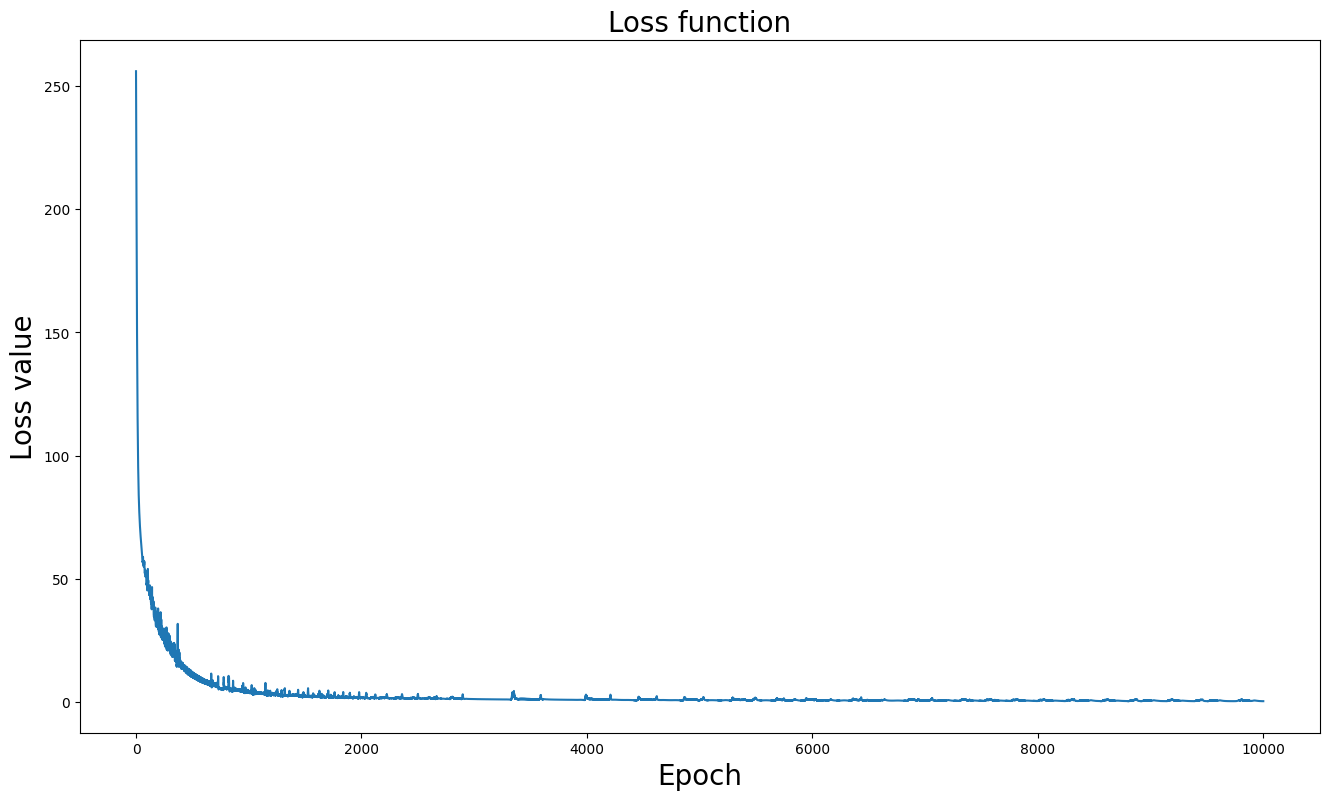

In [28]:
# Print the loss function
plot(range(epochs), losses)
title('Loss function', size=20)
xlabel('Epoch', size=20)
ylabel('Loss value', size=20)

In [29]:
losses[9999]

array(0.48091328, dtype=float32)

**Response:**
At the beginning (epoch=1000 and lr=0.001)  the network converged, but didn't really show good results, the shape loss function wasn't promissing the MSE of the last iteration, was MSE=4.98 which is especially compared to the AR(1) bad, because it actually means that the  LSTM isn't able to get predicted values that are close to the real ones

We increased the number of iteration epoch=10000 and the learning rate to 0.01, and now we have quiet promissing results


**Question 4:**

Compare the predictions of the linear regression AR(1) and the LSTM architecture on the test dataset. Compute the root mean squared errors (for each component) between the predicted values and the truth. Plot also the histograms of the residuals (difference between prediction and truth) for the 2 models. What are the main differences between the ouputs of the AR(1) and the RNN models?

First, you have to transfer the prediction of your LSTM from the GPU.

In [31]:
# Make predictions from the AR1 and LSTM models
y_AR1_hat = AR_1.forward(x_test)
y_RNN_hat, h_hat, c_hat = model_RNN.forward(x_test_LSTM)

# Transfer data from the GPU
y_RNN_hat = y_RNN_hat.cpu()

RMSE-AR1 [0.03458017 0.4746744  0.8054286 ]
RMSE-LSTM [0.6485421 0.7618371 0.7768799]


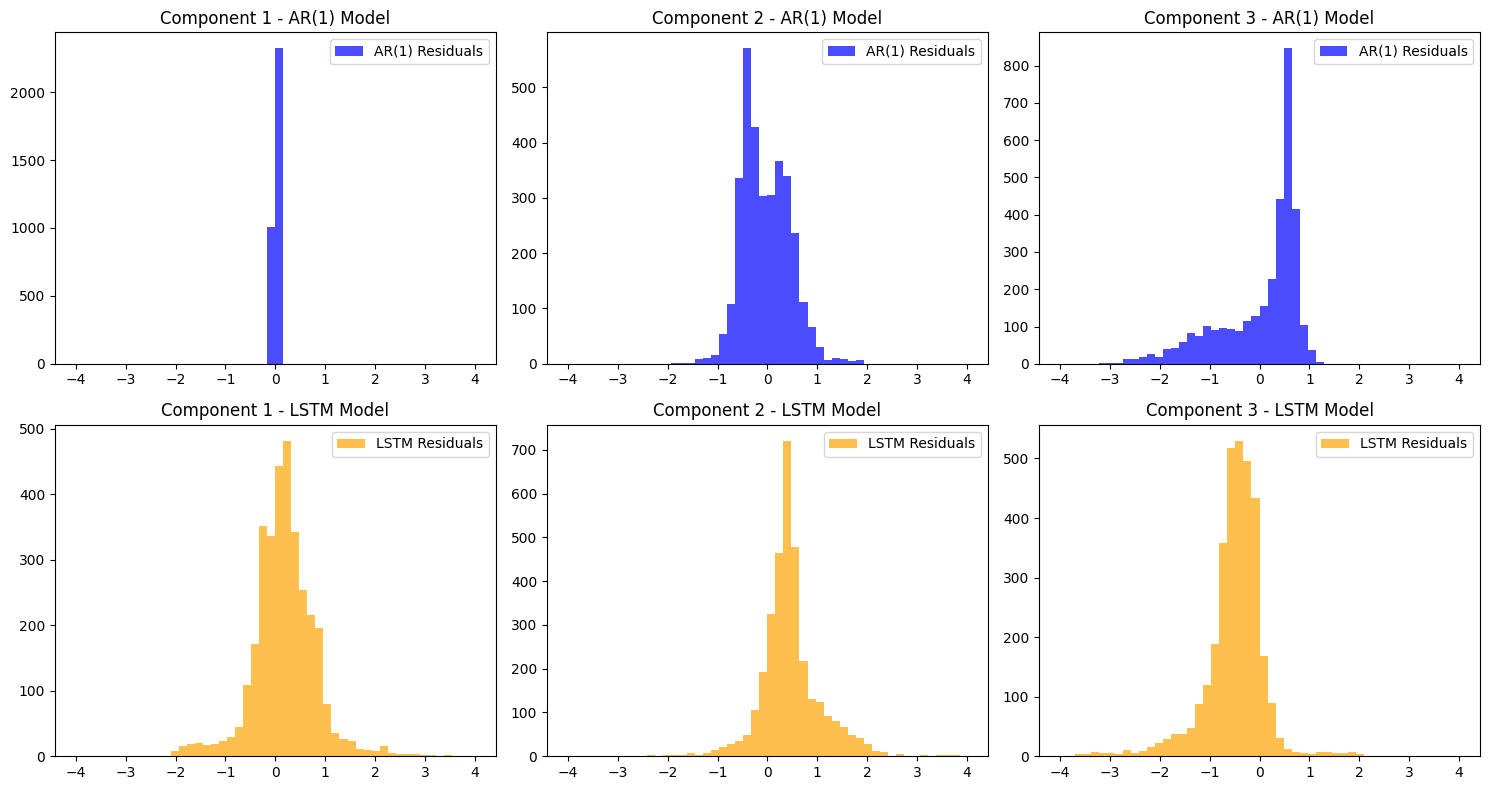

RMSE for AR(1): [0.03458017 0.4746744  0.8054286 ]
RMSE for LSTM: [0.6485421 0.7618371 0.7768799]


In [51]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming you have y_test, y_AR1_hat, and y_RNN_hat as PyTorch tensors

# Compute RMSE for each component
rmse_ar1 = np.sqrt(mean_squared_error(y_test, y_AR1_hat.detach().numpy(), multioutput='raw_values'))
print('RMSE-AR1',rmse_ar1)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_RNN_hat.detach().numpy().reshape(-1, 3), multioutput='raw_values'))
print('RMSE-LSTM',rmse_lstm )



# Determine the common range for the histograms
hist_range = (-np.max(np.abs(all_residuals)), np.max(np.abs(all_residuals)))

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i in range(3):  # Assuming 3 components (adjust if needed)
    axs[0, i].hist(residuals_ar1[:, i], bins=50, range=hist_range, color='blue', alpha=0.7, label='AR(1) Residuals')
    axs[0, i].set_title(f'Component {i+1} - AR(1) Model')
    axs[0, i].legend()

    axs[1, i].hist(residuals_lstm[:, i], bins=50, range=hist_range, color='orange', alpha=0.7, label='LSTM Residuals')
    axs[1, i].set_title(f'Component {i+1} - LSTM Model')
    axs[1, i].legend()

plt.tight_layout()
plt.show()

print("RMSE for AR(1):", rmse_ar1)
print("RMSE for LSTM:", rmse_lstm)




**AR(1) Model:**

**Centered Distribution:**

The data is generally centered around 0, except for x3.
Interpretation: The central tendency around 0 indicates that, on average, the AR(1) model tends to make predictions that balance between overestimation and underestimation.

**Spread/Dispersion of the Distribution:**

The narrow distribution suggests consistent proximity of model predictions to true values.

**Symmetry and Skewness:**

 Some skewness is observed, especially for x3, with a negative skewness indicating a tendency to overestimate.
 Negative skewness implies a bias towards overestimation for x3. Instances where predictions significantly deviate from the true values are observed, particularly in this component.

**LSTM Model:**

**Centered Distribution:**

The histogram is centered around 0.
 The central positioning around 0 suggests that, on average, the LSTM model tends to make predictions that balance between overestimation and underestimation.

**Spread/Dispersion of the Distribution:**

Residuals consistently lower for LSTM.


**Comparaison between both**
Interpretation: The consistently lower residuals for the LSTM model indicate superior accuracy compared to the AR(1) model. The LSTM model produces predictions that are generally closer to the true values, demonstrating higher precision in capturing the underlying patterns of the time series.
Synthesis:

Both models show a tendency to center predictions around 0, but the LSTM model consistently outperforms the AR(1) model, as indicated by the narrower spread of residuals.
The AR(1) model, while generally accurate, exhibits some skewness, especially in x3, indicating a bias towards overestimation.
The LSTM model, with its consistently lower residuals, suggests a higher level of accuracy and precision, making it a more effective model in capturing the complexities of the time series across all components.



**Question 5:**

Now, starting from the last value of *y_test*, use the AR(1) model and the RNN to simulate new data (e.g., a sequence of 1500 time steps). You will need to apply the models recursively. Comment the resulting trajectories: do they look like the original ones?

In [89]:
len_simu = 1500 # length of the simulation
x0_AR1 = y_test[-1,:] # initial condition for AR(1)
x0_LSTM = y_test_LSTM[-100:,:,:] # initial condition for LSTM (needed to learn the neurons in the hidden layer)

# Initialize resulting arrays
x_AR1 = torch.zeros((len_simu,3))
x_RNN = torch.zeros((len_simu,3)).to(device)
x_AR1[0,:] = x0_AR1
x_RNN[0,:] = x0_LSTM[-1,:]

# Estimate h and c of the LSTM using several Lorenz times
x_RNN_tmp, h_hat, c_hat = model_RNN.forward(x0_LSTM)

# Loop on the previous prediction
for i in range(len_simu-1):
  x_AR1[i+1,:] =  AR_1.forward(x_AR1[i,:])
  x_RNN_tmp, h_hat, c_hat = model_RNN.forward_using_last_hidden_layer(x_RNN_tmp,  h_hat, c_hat)
  x_RNN[i+1,:] = x_RNN_tmp[-1,:]

# Generate the true run
x_truth = odeint(Lorenz_63, y_test[-1,:], arange(0.01,(len_simu )*dt,dt), args=(sigma,rho,beta))

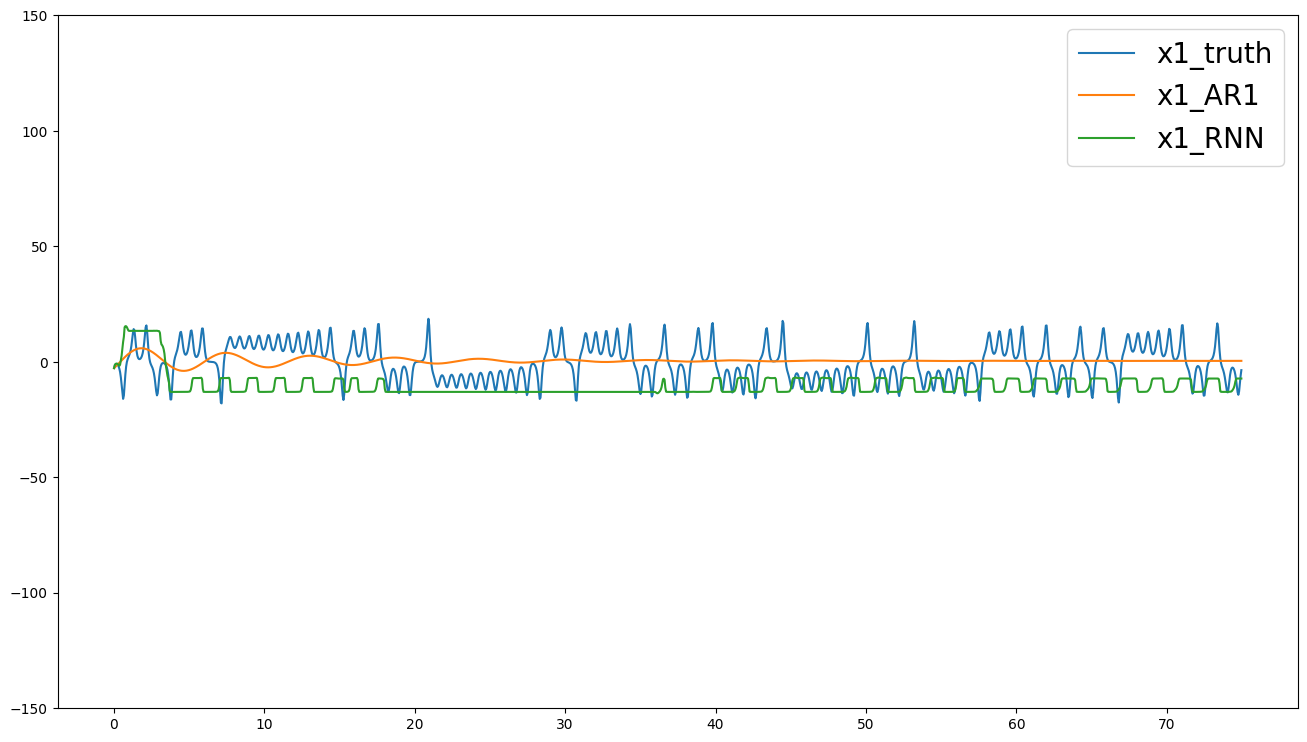

In [90]:
time = arange(0.01,(len_simu)*dt,dt)
fig,ax=plt.subplots()
ax.set_ylim(-150,150)
ax.plot(time,x_truth[:,0])
ax.plot(time,x_AR1[:,0].detach().numpy())
ax.plot(time,x_RNN[:,0].cpu().data.detach().numpy())
legend(['x1_truth','x1_AR1','x1_RNN'],fontsize=20)

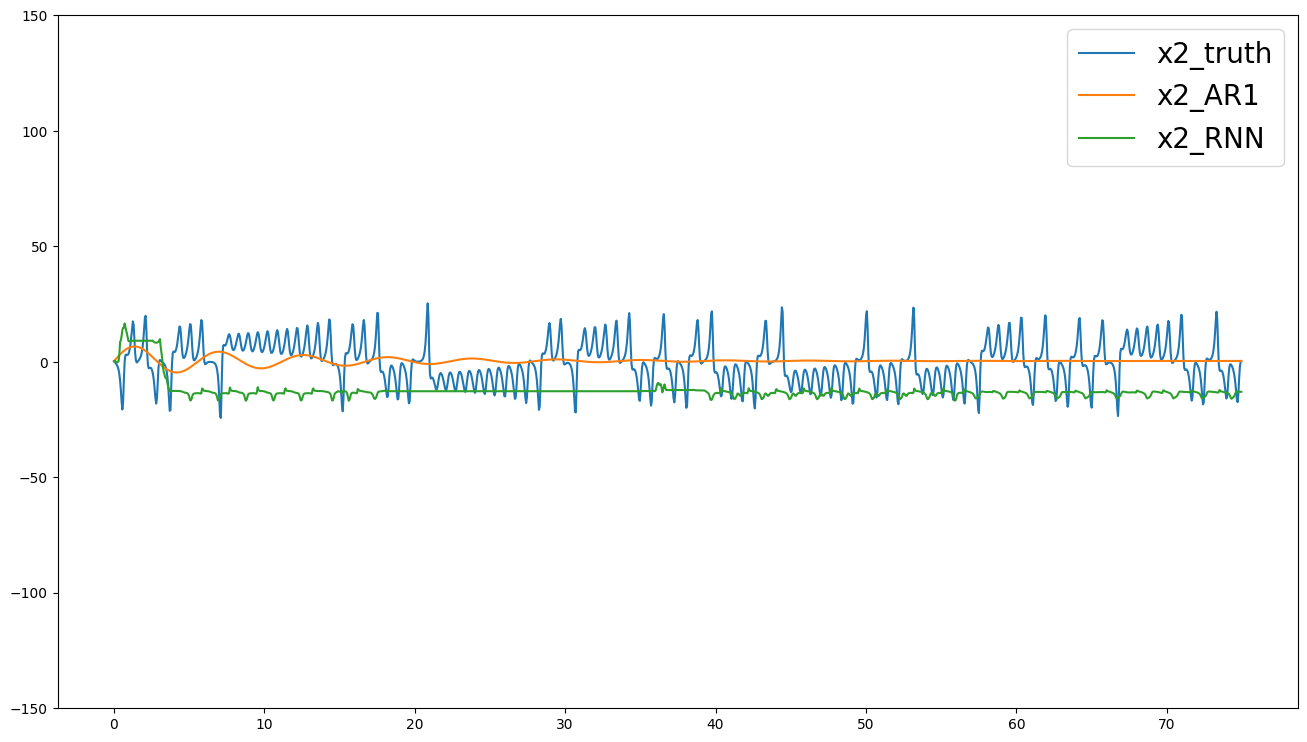

In [91]:
time = arange(0.01,(len_simu)*dt,dt)
fig,ax=plt.subplots()
ax.set_ylim(-150,150)
ax.plot(time,x_truth[:,1])
ax.plot(time,x_AR1[:,1].detach().numpy())
ax.plot(time,x_RNN[:,1].cpu().data.detach().numpy())
legend(['x2_truth','x2_AR1','x2_RNN'],fontsize=20)

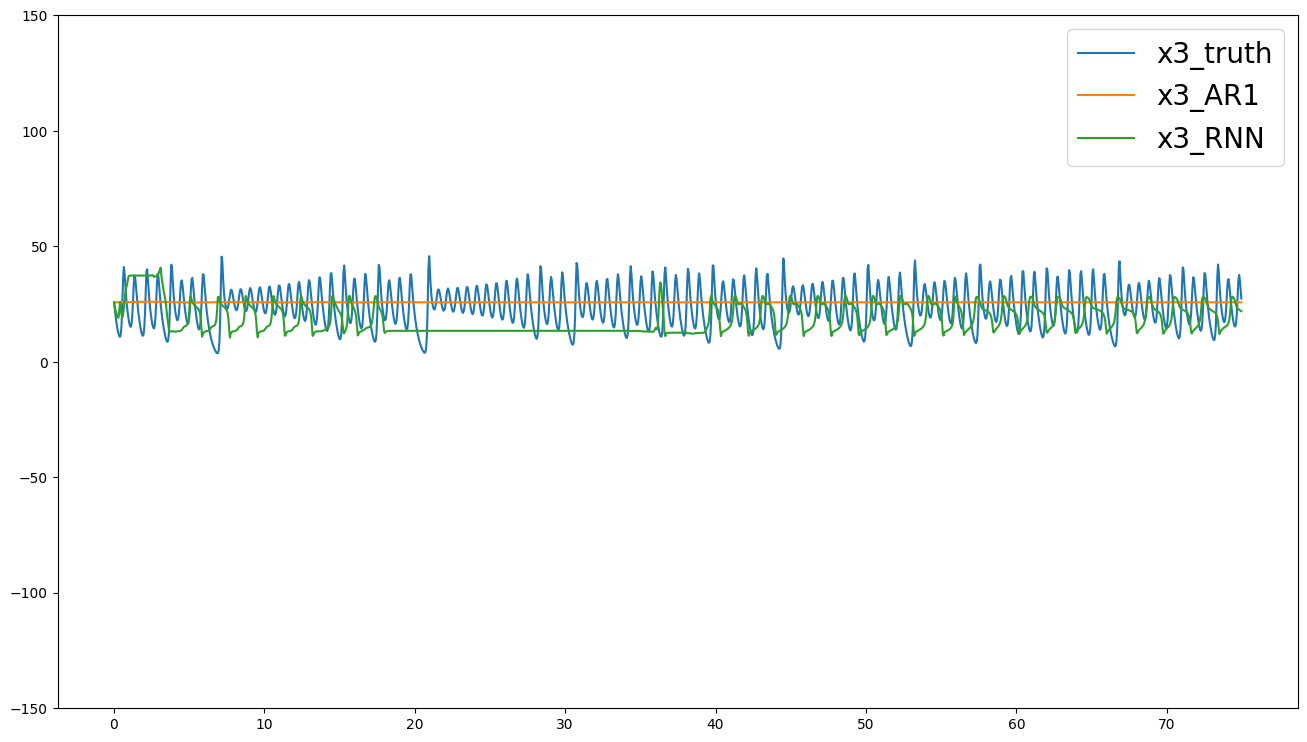

In [92]:
time = arange(0.01,(len_simu)*dt,dt)
fig,ax=plt.subplots()
ax.set_ylim(-150,150)
ax.plot(time,x_truth[:,2])
ax.plot(time,x_AR1[:,2].detach().numpy())
ax.plot(time,x_RNN[:,2].cpu().data.detach().numpy())
legend(['x3_truth','x3_AR1','x3_RNN'],fontsize=20)

**Response:**

We notice, that both models are not quiet able to get a similar shape to the real values, however,  the  RNN always gives better results that than the AR1, It always tends to get closer to the real values, and  even if unable to, the amplitude of the oscillations are smaller for the RNN than for the AR1

We noticed earlier, that when we increased the number of iterations and when we changed the learning rate, we were able to decrease the value of the loss function from 5 to 0.48. This might suggest, that if we increase once again the number of iteration we might be able to predict better


**Question 6 (bonus):**

Propose and implement a new model to increase the quality of the prediction. We suggest to transform the input and take into account more time lags (i.e., $t-1$, $t-2$, $t-3$) to explain the Lorenz-63 system at time $t$. This can be done using a linear regression and in that case, we are talking about a AR(3) model.

In [ ]:
#############
### TO DO ###
#############